In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import sent_tokenize, word_tokenize

import gensim
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim import models
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [8]:
df = pd.read_csv('tokped_bersih3 fix - Copy.csv')
data = df['Cleaned_review']


In [9]:
data = data.fillna(str(" "))

In [10]:
token = []  
for i in data: 
#     print(i)
    tokenized_sents = word_tokenize(i) 
    token.append(tokenized_sents)

In [15]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).


bigram = Phrases(token, min_count=3)
trigram = Phrases(bigram[token])

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [16]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [17]:
#Create a Dictionary

token_postag = make_bigrams(token)

dictionary = Dictionary(token_postag)
print('Jumlah kata unik pada seluruh dokumen:', len(dictionary))


dictionary.filter_extremes(no_below=5, no_above=0.80)
print('Jumlah kata unik setelah dilakukan filter :', len(dictionary))

Jumlah kata unik pada seluruh dokumen: 2319
Jumlah kata unik setelah dilakukan filter : 327


In [18]:
#Vektorisasi Data (Create Corpus)

corpus = [dictionary.doc2bow(text) for text in token_postag]
print('Jumlah kata Unik: %d' % len(dictionary))
print('Jumlah dokumen: %d' % len(corpus))

#Build TF-IDF Model
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Jumlah kata Unik: 327
Jumlah dokumen: 3067


In [19]:
tf_vectorizer = CountVectorizer(max_df=0.80, min_df=5)
document = [' '.join(d) for d in token_postag]
wiki_tf = tf_vectorizer.fit_transform(document)

### Menentukan Topik Terbaik menggunakan Coherence Model

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, step, start):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
%%time

import warnings
warnings.simplefilter("ignore", UserWarning)

start, step, limit = 2, 1, 5
coherence_val, kCV = [], 10

for i in range(kCV):
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=token_postag, limit=limit,
                                                       step = step, start = start)
    coherence_val.append(coherence_values)

coherence_w = np.mean(np.array(coherence_val),axis = 0)

Wall time: 1min 19s


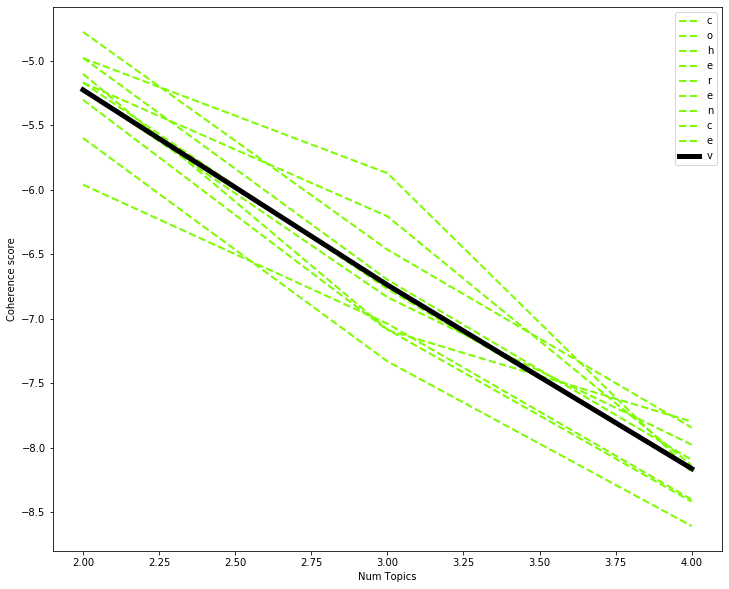

In [22]:
# Show graph

x = range(start, limit, step)

plt.figure(figsize=(12,10))

for c in coherence_val:
    plt.plot(x, c, '--', color = 'lawngreen', linewidth = 2)
plt.plot(x, coherence_w, '-', color = 'black', linewidth = 5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
for m, cv in zip(x, coherence_w):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of -5.225212
Num Topics = 3  has Coherence Value of -6.738137
Num Topics = 4  has Coherence Value of -8.163176


In [24]:
# Melihat index yang memiliki nilai terbesar
num_topics = np.argmax(coherence_w)+2
num_topics

2